In [1]:
import numpy as np 
import pandas as pd 
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras

import re
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

**1.Load Dataset**

In [3]:
df = pd.read_csv("/content/drive/MyDrive/DATASET/machine_translation/eng_-french.csv",names=['english','french'])
print(df.head(5))

print(f"\n\n Shape of the data >>{df.shape}")
df.sample(5)

                   english                  french
0  English words/sentences  French words/sentences
1                      Hi.                  Salut!
2                     Run!                 Cours !
3                     Run!                Courez !
4                     Who?                   Qui ?


 Shape of the data >>(175622, 2)


,english,french
110677,My secretary said it was urgent.,Mon secrétaire a dit que c'était urgent.
63743,That looked like it hurt.,On aurait dit que ça faisait mal.
26930,What is your offer?,Quelle est ton offre ?
128747,He blew out the candles on the cake.,Il a soufflé les bougies du gâteau.
87821,Are you going to Tom's party?,Vas-tu à la fête de Tom?


**2.Check Dataset**
* duplicates
* NA values

In [4]:
print("Unique values before dropping duplicates")
print(df.english.nunique())
print(df.french.nunique())

df.drop_duplicates(subset=['english'],inplace=True)
df.drop_duplicates(subset=['french'],inplace=True)

print("\n\nUnique values before dropping duplicates")
print(df.english.nunique())
print(df.french.nunique())

Unique values before dropping duplicates
123101
165976


Unique values before dropping duplicates
116544
116544


In [5]:
print("Checking NA values\n")
print(df.isnull().any(),'\n')
print(df.isnull().sum())

Checking NA values

english    False
french     False
dtype: bool 

english    0
french     0
dtype: int64


**3.Preprocessing Text**
* lowercase for both
* drop stopwords for only english -> let's not remove stopwords
* drop .'!#$%&\'()*+,-./:;<=>?@[\\]^ `{|}~
* switch contractions for eng


In [6]:
print("before preprocessing")
df.tail(6)

before preprocessing


,english,french
175616,We need to uphold laws against discrimination ...,Nous devons faire respecter les lois contre la...
175617,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175618,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175619,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175620,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
175621,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                "could've": "could have", "couldn't": "could not", "didn't": "did not", 
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
                "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have",
                "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                "there's": "there is", "here's": "here is","they'd": "they would", 
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", 
                "when've": "when have", "where'd": "where did", "where's": "where is", 
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                "will've": "will have", "won't": "will not", "won't've": "will not have", 
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                "y'all're": "you all are","y'all've": "you all have", "you'd": "you would", 
                "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                "you're": "you are", "you've": "you have"}


eng_stopwords = set(stopwords.words("english"))

#language => either 'english' or 'french'
def preprocess(sentence,language):
    sentence = sentence.lower()
    if language == "english":
        sentence = ' '.join([contractions[word] if word in contractions else word for word in sentence.split()])
#         sentence = ' '.join([word for word in sentence.split() if word not in eng_stopwords])
    sentence = re.sub(r"[.'!#$%&\'()*+,-./:;<=>?@[\\]^ `{|}~]"," ",sentence)
    sentence = ' '.join([word for word in sentence.split()])
    
    return sentence
    

In [11]:
df.english = df.english.apply(lambda x:preprocess(x,'english'))
df.french = df.french.apply(lambda x:preprocess(x,'french'))

print(df.shape,'\n')
df.info()

(116544, 2) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116544 entries, 0 to 175621
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  116544 non-null  object
 1   french   116544 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [12]:
print("after preprocessing")
df.tail(6)

after preprocessing


,english,french
175616,we need to uphold laws against discrimination ...,nous devons faire respecter les lois contre la...
175617,"top-down economics never works, said obama. ""t...","« l'économie en partant du haut vers le bas, ç..."
175618,a carbon footprint is the amount of carbon dio...,une empreinte carbone est la somme de pollutio...
175619,death is something that we are often discourag...,la mort est une chose qu'on nous décourage sou...
175620,since there are usually multiple websites on a...,puisqu'il y a de multiples sites web sur chaqu...
175621,if someone who does not know your background s...,si quelqu'un qui ne connaît pas vos antécédent...


**4.Train / Test separate**

sostoken et eostoken pour indiquer le debut de la phrase ou la fin de la phrase

In [13]:
df["french_input"] = df.french.apply(lambda x:'sostoken ' + x)
df["french_label"] = df.french.apply(lambda x:x + ' eostoken')

encoder_input = np.array(df.english)
decoder_input = np.array(df.french_input)
decoder_label = np.array(df.french_label)

indices = np.arange(116544)
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_label = decoder_label[indices]

#print(encoder_input[:10])
print(decoder_label[:10])
#df.head()

["il n'y avait pas de signature sur le contrat. eostoken"
 'pourquoi ne vous asseyez-vous pas ici sur le canapé ? eostoken'
 'il a une personnalité intrigante. eostoken'
 'je suis plus intelligent que toi. eostoken'
 'tom va le regretter. eostoken' 'tom a écrit ça pour moi. eostoken'
 'je suis désolée, mais tu dois partir. eostoken'
 'ils ne voulaient pas passer beaucoup de temps à en parler. eostoken'
 'mes affaires prospèrent. eostoken'
 'les marchandises sont arrivées hier. eostoken']


In [14]:
print(encoder_input[:10])

['there was no signature on the contract.'
 'why do not you sit right there on the couch?'
 'he has an intriguing personality.' 'i am smarter than you.'
 'tom is going to regret it.' 'tom wrote it for me.'
 'i am sorry, but you need to leave.'
 'they did not want to spend much time talking about it.'
 'my business is prospering.' 'the goods arrived yesterday.']


In [15]:
decoder_input[:10]

array(["sostoken il n'y avait pas de signature sur le contrat.",
       'sostoken pourquoi ne vous asseyez-vous pas ici sur le canapé ?',
       'sostoken il a une personnalité intrigante.',
       'sostoken je suis plus intelligent que toi.',
       'sostoken tom va le regretter.',
       'sostoken tom a écrit ça pour moi.',
       'sostoken je suis désolée, mais tu dois partir.',
       'sostoken ils ne voulaient pas passer beaucoup de temps à en parler.',
       'sostoken mes affaires prospèrent.',
       'sostoken les marchandises sont arrivées hier.'], dtype=object)

In [17]:
total = df.shape[0]
test_size = 0.3

train_encoder_input = encoder_input[:-int(total*test_size)]
train_decoder_input = decoder_input[:-int(total*test_size)]
train_decoder_label = decoder_label[:-int(total*test_size)]

test_encoder_input = encoder_input[-int(total*test_size):]
test_decoder_input = decoder_input[-int(total*test_size):]
test_decoder_label = decoder_label[-int(total*test_size):]

print("train dataset shape")
print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print("\n\ntest dataset shape")
print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

train dataset shape
(81581,)
(81581,)
(81581,)


test dataset shape
(34963,)
(34963,)
(34963,)


**5.Tokenize & Pad sequences**

In [ ]:
eng_tok = Tokenizer()
eng_tok.fit_on_texts(train_encoder_input)
print(f"Number of unique words used in english sentences >> {len(eng_tok.index_word)}")

fr_tok = Tokenizer()
fr_tok.fit_on_texts(train_decoder_input)
fr_tok.fit_on_texts(train_decoder_label)
print(f"Number of unique words used in french sentences >> {len(fr_tok.index_word)}")

Number of unique words used in english sentences >> 12620
Number of unique words used in french sentences >> 21283


In [ ]:
total_counts = 0
rare_counts = 0
total_freq = 0
rare_freq = 0

least_occurence = 3
for k,v in eng_tok.word_counts.items():
    total_counts +=1
    total_freq += v
    if v < least_occurence:
        rare_counts+=1
        rare_freq += v

print("="*25,"english","="*25)
print(f"{rare_counts} of {total_counts} words are used less than {least_occurence}times,")
print(f"which is only {np.round(rare_counts/total_counts*100)}% of total words used")
print(f"But they occupy {np.round(rare_freq/total_freq*100)}% of total frequency ")

========================= english =========================
6583 of 12620 words are used less than 3times,
which is only 52.0% of total words used
But they occupy 2.0% of total frequency 


In [ ]:
total_counts = 0
rare_counts = 0
total_freq = 0
rare_freq = 0

least_occurence = 3
for k,v in fr_tok.word_counts.items():
    total_counts +=1
    total_freq += v
    if v < least_occurence:
        rare_counts+=1
        rare_freq += v

print("="*25,"french","="*25)
print(f"{rare_counts} of {total_counts} words are used less than {least_occurence}times,")
print(f"which is only {np.round(rare_counts/total_counts*100)}% of total words used")
print(f"But they occupy {np.round(rare_freq/total_freq*100)}% of total frequency ")

========================= french =========================
9354 of 21283 words are used less than 3times,
which is only 44.0% of total words used
But they occupy 1.0% of total frequency 


In [ ]:
eng_word_size = 6000
eng_vocab_size = eng_word_size+1
fr_word_size = 12000
fr_vocab_size = fr_word_size+1

eng_tok = Tokenizer(num_words=eng_word_size)
eng_tok.fit_on_texts(train_encoder_input)

train_encoder_input = eng_tok.texts_to_sequences(train_encoder_input)
test_encoder_input = eng_tok.texts_to_sequences(test_encoder_input)

fr_tok = Tokenizer(num_words=fr_word_size)
fr_tok.fit_on_texts(train_decoder_input)
fr_tok.fit_on_texts(train_decoder_label)

train_decoder_input = fr_tok.texts_to_sequences(train_decoder_input)
train_decoder_label = fr_tok.texts_to_sequences(train_decoder_label)

test_decoder_input = fr_tok.texts_to_sequences(test_decoder_input)
test_decoder_label = fr_tok.texts_to_sequences(test_decoder_label)

english
mean >>  6.573430087888111
french
mean >>  7.78162807516456


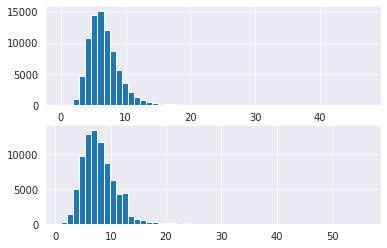

In [ ]:
print("english")
eng_lens = [len(seq) for seq in train_encoder_input]
print("mean >> ",np.mean(eng_lens))
plt.subplot(2,1,1)
plt.hist(eng_lens,bins=50)


print("french")
fr_lens = [len(seq) for seq in train_decoder_input]
print("mean >> ",np.mean(fr_lens))
plt.subplot(2,1,2)
plt.hist(fr_lens,bins=50)
plt.show()

In [ ]:
eng_sequence_size = 10
fr_sequence_size = 20

train_encoder_input = pad_sequences(train_encoder_input,padding='post',truncating='post',maxlen=eng_sequence_size)
test_encoder_input = pad_sequences(test_encoder_input,padding='post',truncating='post',maxlen=eng_sequence_size)

train_decoder_input = pad_sequences(train_decoder_input,padding='post',truncating='post',maxlen=fr_sequence_size)
train_decoder_label = pad_sequences(train_decoder_label,padding='post',truncating='post',maxlen=fr_sequence_size)

test_decoder_input = pad_sequences(test_decoder_input,padding='post',truncating='post',maxlen=fr_sequence_size)
test_decoder_label = pad_sequences(test_decoder_label,padding='post',truncating='post',maxlen=fr_sequence_size)

print("train dataset shape")
print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print("\n\ntest dataset shape")
print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

train dataset shape
(81581, 10)
(81581, 20)
(81581, 20)


test dataset shape
(34963, 10)
(34963, 20)
(34963, 20)


**6.Encoder-Decoder Model : Stacked LSTM + Luong Attention**

In [ ]:
from keras.layers import Input,Embedding,LSTM,Dense,Concatenate,Attention
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K

#hyperparameters
embedding_size = 256
hidden_size = 256

# trainer model (generator model will use the same encoder tho)
encoder_input = Input(shape=[eng_sequence_size])
encoder_embedding = Embedding(eng_vocab_size,embedding_size,mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)

encoder_lstm1 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output1,encoder_h1,encoder_c1 = encoder_lstm1(encoder_embedded)

encoder_lstm2 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output2,encoder_h2,encoder_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output3,encoder_h3,encoder_c3 = encoder_lstm3(encoder_output1)

decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(fr_vocab_size,embedding_size,mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)

decoder_lstm = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
decoder_output,_,_ = decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])

attn_layer = Attention()
attn_context = attn_layer([decoder_output,encoder_output3])

decoder_output = Concatenate(axis=-1)([decoder_output,attn_context])
tanh_dense= Dense(hidden_size*2,activation=K.tanh)
decoder_output = tanh_dense(decoder_output)

softmax_dense = Dense(fr_vocab_size,activation='softmax')
decoder_output = softmax_dense(decoder_output)

trainer_model = Model([encoder_input,decoder_input],decoder_output)
trainer_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

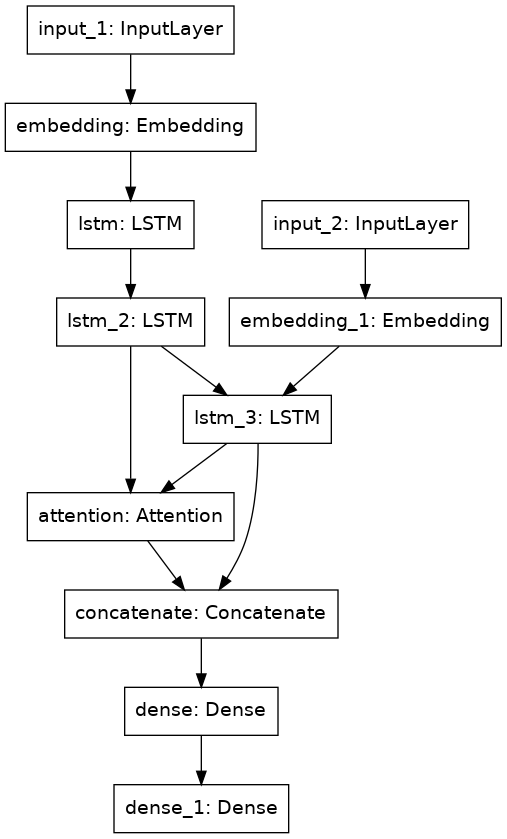

In [ ]:
plot_model(trainer_model)

In [ ]:
trainer_hist =trainer_model.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=25,batch_size=128,validation_split=0.2)

Epoch 1/25
510/510 [==============================] - 1000s 2s/step - loss: 2.3693 - accuracy: 0.1719 - val_loss: 1.7084 - val_accuracy: 0.2926
Epoch 2/25
510/510 [==============================] - 988s 2s/step - loss: 1.5887 - accuracy: 0.3204 - val_loss: 1.3408 - val_accuracy: 0.4012
Epoch 3/25
510/510 [==============================] - 998s 2s/step - loss: 1.2078 - accuracy: 0.4336 - val_loss: 1.1069 - val_accuracy: 0.4955
Epoch 4/25
510/510 [==============================] - 990s 2s/step - loss: 0.9578 - accuracy: 0.5283 - val_loss: 0.9671 - val_accuracy: 0.5559
Epoch 5/25
510/510 [==============================] - 1004s 2s/step - loss: 0.7817 - accuracy: 0.5926 - val_loss: 0.8856 - val_accuracy: 0.5905
Epoch 6/25
510/510 [==============================] - 996s 2s/step - loss: 0.6623 - accuracy: 0.6394 - val_loss: 0.8375 - val_accuracy: 0.6130
Epoch 7/25
510/510 [==============================] - 993s 2s/step - loss: 0.5770 - accuracy: 0.6741 - val_loss: 0.8106 - val_accuracy: 0.62

In [ ]:
#generator model
gen_encoder = Model([encoder_input],[encoder_output3,encoder_h3,encoder_c3])

gen_decoder_values_input = Input(shape=(eng_sequence_size,hidden_size))
gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])

attn_context = attn_layer([gen_decoder_output,gen_decoder_values_input])
gen_decoder_output = Concatenate(axis=-1)([gen_decoder_output,attn_context])

gen_decoder_output = tanh_dense(gen_decoder_output)
gen_decoder_output = softmax_dense(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_values_input,gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output,gen_decoder_h,gen_decoder_c])

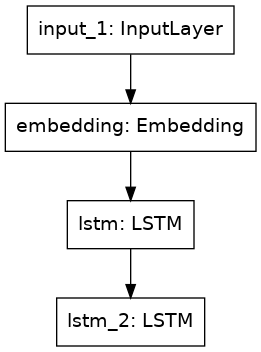

In [ ]:
plot_model(gen_encoder)

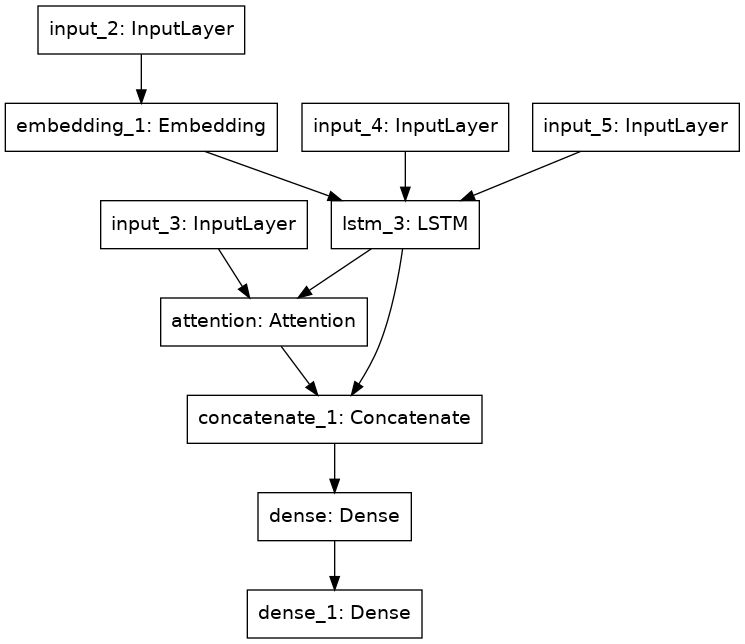

In [ ]:
plot_model(gen_decoder)

In [ ]:
def seq2eng(seq):
    ret =[]
    for n in seq:
        if n != 0:
            ret.append(eng_tok.index_word[n])
    ret = ' '.join(ret)
    return ret

def seq2fr(seq):
    ret =[]
    for n in seq:
        if n != 0 and fr_tok.index_word[n] != 'eostoken':
            ret.append(fr_tok.index_word[n])
    ret = ' '.join(ret)
    return ret

In [ ]:
def generate_from_encoder_input(encoder_input):
    encoder_input = encoder_input.reshape(1,-1)
    values,h,c = gen_encoder.predict(encoder_input)
    
    single_tok = np.zeros((1,1))
    single_tok[0,0] = fr_tok.word_index['sostoken']
    decoder_input = single_tok
    
    generated = []
    count = 0
    while(True):
        decoder_output,new_h,new_c = gen_decoder.predict([decoder_input]+[values,h,c])
        count +=1
        
        sampled_index = np.argmax(decoder_output[0,-1,:])
        sampled_word = fr_tok.index_word[sampled_index]
        
        if sampled_word != 'eostoken' and sampled_index != 0:
            generated.append(sampled_word)
        if count >= fr_sequence_size or sampled_word == 'eostoken':
            break
        
        h,c = new_h,new_c
        decoder_input[0,0] = sampled_index
    
    generated = ' '.join(generated)
    return generated

In [ ]:
for i in range(520,525):
    print("\n<<sample encoder input english sentence>>")
    print(seq2eng(train_encoder_input[i]))
    print("\n")
    print("<<sample generated french sentence>>")
    print(generate_from_encoder_input(train_encoder_input[i]))
    print("\n")
    print("<<answer french sentence>>")
    print(seq2fr(train_decoder_label[i]))
    print("========================================\n")


<<sample encoder input english sentence>>
we are headed in the right direction


<<sample generated french sentence>>
nous nous dirigeons dans la bonne direction


<<answer french sentence>>
nous nous dirigeons dans la bonne direction


<<sample encoder input english sentence>>
the police executed a search warrant on my brother's apartment


<<sample generated french sentence>>
la police a exercé un mandat de perquisition dans l'appartement de mon frère


<<answer french sentence>>
la police a exercé un mandat de perquisition dans l'appartement de mon frère


<<sample encoder input english sentence>>
tom has a soft spot for mary


<<sample generated french sentence>>
tom a un don à mary pour marie


<<answer french sentence>>
tom a un faible pour marie


<<sample encoder input english sentence>>
at least i will die happy


<<sample generated french sentence>>
au moins je mourrai heureux


<<answer french sentence>>
au moins je mourrai heureux


<<sample encoder input english sentence>

**7.Evaluate the model**
1. first on train dataset
2. next on test dataset

In [ ]:
idx = [24,1525,666,2222,52212]

print("Results on Train Dataset")
for i in idx:
    print("\nINPUT ENG>>")
    print(seq2eng(train_encoder_input[i]))
    print("\n")
    print("GENERATED FR>>")
    print(generate_from_encoder_input(train_encoder_input[i]))
    print("\n")
    print("ANSWER FR>>")
    print(seq2fr(train_decoder_label[i]))
    print("=====================================================================\n")

Results on Train Dataset

INPUT ENG>>
you think i am stupid do not you


GENERATED FR>>
tu penses que je ne te mens pas


ANSWER FR>>
tu penses que je suis stupide n'est ce pas


INPUT ENG>>
he is not lazy on the contrary i think he


GENERATED FR>>
il n'est pas fainéant au contraire je crois que c'est un beau romancier


ANSWER FR>>
il n'est pas fainéant au contraire je crois que c'est un grand


INPUT ENG>>
to get to the museum you need to take that


GENERATED FR>>
pour aller au musée vous devez prendre ce bus


ANSWER FR>>
pour vous rendre au musée vous devez prendre ce bus


INPUT ENG>>
that is the girl whose father is a doctor


GENERATED FR>>
c'est la fille dont le père est médecin


ANSWER FR>>
c'est la fille dont le père est médecin


INPUT ENG>>
i can see right through you


GENERATED FR>>
je peux voir clair en vous


ANSWER FR>>
je peux voir clair en vous



In [ ]:
idx = [24,1525,666,2222,52212]

print("Results on Test Dataset")
for i in idx:
    print("\nINPUT ENG>")
    print(seq2eng(test_encoder_input[i]))
    print("\n")
    print("<<GENERATED FR>>")
    print(generate_from_encoder_input(test_encoder_input[i]))
    print("\n")
    print("<<ANSWER FR>>")
    print(seq2fr(test_decoder_label[i]))
    print("=====================================================================\n")

Results on Test Dataset

INPUT ENG>
everyone is very proud of you


<<GENERATED FR>>
tout le monde est très fier de toi


<<ANSWER FR>>
tout le monde est très fier de vous


INPUT ENG>
tom does not know where mary usually goes skiing


<<GENERATED FR>>
tom ne sait pas où marie aime skier


<<ANSWER FR>>
tom ne sait pas où marie a l'habitude d'aller skier


INPUT ENG>
you touched my heart


<<GENERATED FR>>
tu as touché le cœur


<<ANSWER FR>>
tu m'as touché au cœur


INPUT ENG>
i am on the wrong bus


<<GENERATED FR>>
je suis au mauvais bus


<<ANSWER FR>>
je suis dans le mauvais bus


INPUT ENG>


IndexError: index 52212 is out of bounds for axis 0 with size 34963